In [1]:
# 데이터 다운로드 링크 : http://www.manythings.org/anki
# Base Code : https://wikidocs.net/24996
# 참고 : https://discuss.pytorch.org/t/understanding-lstm-input/31110
import pandas as pd
import warnings
import torch
import torch.nn as nn
from torch import optim
warnings.filterwarnings('ignore')
# lines = pd.read_csv('dataset/fra.txt', names=['src', 'tar','drop'], sep='\t')
lines.drop(['drop'], inplace=True, axis=1)
len(lines)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
SOS_token = 0
EOS_token = 1

raw = ["I feel hungry.	나는 배가 고프다.",
       "Pytorch is very easy.	파이토치는 매우 쉽다.",
       "Pytorch is a framework for deep learning.	파이토치는 딥러닝을 위한 프레임워크이다.",
       "Pytorch is very clear to use.	파이토치는 사용하기 매우 직관적이다."]

In [4]:
SOURCE_MAX_LENGTH = 10
TARGET_MAX_LENGTH = 12
load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)


reading corpus...
Read {} sentence pairs 4
[['i feel hungry.', '나는 배가 고프다.'], ['pytorch is very easy.', '파이토치는 매우 쉽다.'], ['pytorch is a framework for deep learning.', '파이토치는 딥러닝을 위한 프레임워크이다.'], ['pytorch is very clear to use.', '파이토치는 사용하기 매우 직관적이다.']]
Trimmed to 4 sentence pairs
Counting words...
source vocab size =  17
target vocab size =  13


In [1]:
def tensorize(vocab, sentence):
    indexs = [vocab.vocab2index[word] for word in sentence.split(" ")]
    indexs.append(vocab.vocab2index["<EOS>"])
    return torch.Tensor(indexs).long().to(device).view(-1,1)

# GRU seq2seq

In [61]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.hidden_size = 16
        self.embedding = nn.Embedding(load_source_vocab.n_vocab, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
    def forward(self, x, hidden):
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        return x, hidden

In [113]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.hidden_size = 16
        self.embedding = nn.Embedding(load_target_vocab.n_vocab, self.hidden_size)
        self.lstm = nn.GRU(self.hidden_size, self.hidden_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.out = nn.Linear(self.hidden_size, load_target_vocab.n_vocab)
        
    def forward(self, X, hidden):
        X = self.embedding(X)
        X = X.view(1, 1, -1)
        X, hidden = self.lstm(X,hidden)
        X = self.softmax(self.out(X[0]))
        return X, hidden
        
        

In [143]:
# hidden_state = torch.zeros(1,1,16).to(device)
# cell_state = torch.zeros(1,1,16).to(device)

dec = Decoder().to(device)
X, hidden_state, cell_state = dec(target_tensor[0], hidden_state, cell_state)

test
torch.Size([1, 16])
torch.Size([1, 1, 16])


# LSTM Train

In [30]:
%%time
import random
encoder = Encoder().to(device)
decoder = Decoder().to(device)
learning_rate=0.05
n_iter = 2000
loss_list = []

loss_total = 0
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

training_batch = [random.choice(load_pairs) for _ in range(n_iter)]
training_source = [tensorize(load_source_vocab, pair[0]) for pair in training_batch]
training_target = [tensorize(load_target_vocab, pair[1]) for pair in training_batch]



criterion = nn.NLLLoss()
for i in range(1, n_iter+1):
    source_tensor = training_source[i-1]
    target_tensor = training_target[i-1]
    
    encoder_hidden = torch.zeros([1,1,encoder.hidden_size]).to(device)    
    encoder_cell = torch.zeros([1,1,encoder.hidden_size]).to(device)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    source_length = source_tensor.size(0)
    target_length = target_tensor.size(0)
    
    loss = 0

    for enc_input in range(source_length):
        _, encoder_hidden, encoder_cell = encoder(source_tensor[enc_input], encoder_hidden, encoder_cell)
    # 한 문장의 encoder 끝
        
    decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_cell  = decoder(decoder_input, decoder_hidden,decoder_cell)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]
        
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    loss_iter = loss.item() / target_length
    loss_total += loss_iter
    
    if i % 1 == 0:
        loss_list.append(loss_total)
        loss_avg = loss_total / 1
        loss_total = 0
#         print("[{} - {}%] loss = {:05.4f}".format(i, i/n_iter * 100, loss_avg))

Wall time: 28.5 s


# GRU Train

In [ ]:
%%time
import random
encoder = Encoder().to(device)
decoder = Decoder().to(device)
learning_rate=0.01
n_iter = 2000
loss_list = []

loss_total = 0
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

training_batch = [random.choice(load_pairs) for _ in range(n_iter)]
training_source = [tensorize(load_source_vocab, pair[0]) for pair in training_batch]
training_target = [tensorize(load_target_vocab, pair[1]) for pair in training_batch]



criterion = nn.NLLLoss()
for i in range(1, n_iter+1):
    source_tensor = training_source[i-1]
    target_tensor = training_target[i-1]
    
    encoder_hidden = torch.zeros([1,1,encoder.hidden_size]).to(device)    
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    source_length = source_tensor.size(0)
    target_length = target_tensor.size(0)
    
    loss = 0

    for enc_input in range(source_length):
        _, encoder_hidden = encoder(source_tensor[enc_input], encoder_hidden)
    # 한 문장의 encoder 끝
        
    decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]
        
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    loss_iter = loss.item() / target_length
    loss_total += loss_iter
    
    if i % 100 == 0:
        loss_list.append(loss_total)
        loss_avg = loss_total / 100
        loss_total = 0
        print("[{} - {}%] loss = {:05.4f}".format(i, i/n_iter * 100, loss_avg))

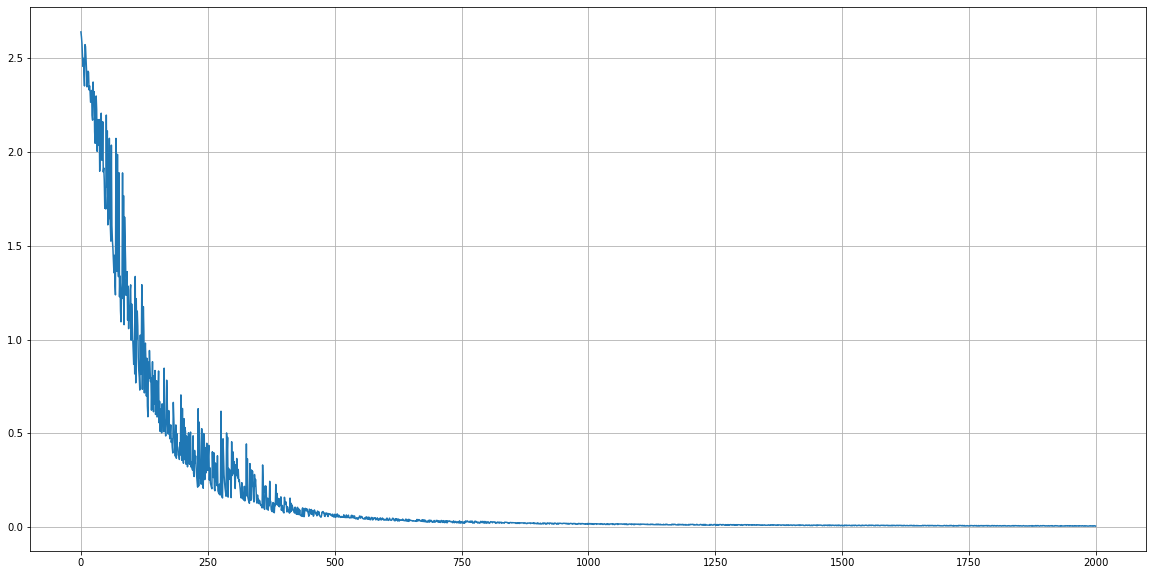

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,10))
plt.plot(loss_list)
plt.grid()
plt.savefig('loss.png')

In [28]:
for pair in load_pairs:
    print(">", pair[0])
    print("=", pair[1])
    source_tensor = tensorize(load_source_vocab, pair[0])
    source_length = source_tensor.size()[0]
    encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)
    encoder_cell = torch.zeros([1, 1, encoder.hidden_size]).to(device)
    
    for ei in range(source_length):
        _, encoder_hidden, encoder_cell = encoder(source_tensor[ei], encoder_hidden,encoder_cell)
        
    decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
    decoder_hidden = encoder_hidden.to(device)
    decoder_cell = encoder_cell.to(device)
    decoded_words = []
    
    for di in range(12):
        decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden,
                                                              decoder_cell)
        _, top_index = decoder_output.data.topk(1)
        
        if top_index.item() == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(load_target_vocab.index2vocab[top_index.item()])
            
        decoder_input = top_index.squeeze().detach()
        
    predict_words = decoded_words
    predict_sentence = " ".join(predict_words)
    print("<", predict_sentence)
    print("")

> i feel hungry.
= 나는 배가 고프다.
< 나는 배가 고프다. <EOS>

> pytorch is very easy.
= 파이토치는 매우 쉽다.
< 파이토치는 매우 쉽다. <EOS>

> pytorch is a framework for deep learning.
= 파이토치는 딥러닝을 위한 프레임워크이다.
< 파이토치는 딥러닝을 위한 프레임워크이다. <EOS>

> pytorch is very clear to use.
= 파이토치는 사용하기 매우 직관적이다.
< 파이토치는 사용하기 매우 직관적이다. <EOS>

